In [1]:
import importlib
import local_utils; importlib.reload(local_utils)
from local_utils import *

Using TensorFlow backend.


Import time: 10.149123668670654
Import time: 9.965896606445312e-05


In [2]:
global_start = time()

In [3]:
train_df = pd.read_csv(DATA_DIR + '/train_v2.csv')
test_df = pd.read_csv(DATA_DIR + '/sample_submission_v2.csv')

label_map, inv_label_map, Y = process_labels(train_df)
print("Shape of Y {}".format(Y.shape))

train_folds, valid_folds = stratified_kfold_sampling(Y, n_splits=10, random_state=1000)
print("Shape of train folds {}".format(train_folds.shape))
print("Shape of valid folds {}".format(valid_folds.shape))

image_size = 128

Shape of Y (40479, 17)
Shape of train folds (10,)
Shape of valid folds (10,)


In [4]:
model_name = "deep_model_vgg19"

fold_inx = 1
batch_size = 32
all_steps = np.ceil(len(Y)/batch_size)
train_steps = np.ceil(len(train_folds[fold_inx])/batch_size)
valid_steps = np.ceil(len(valid_folds[fold_inx])/batch_size)
test_steps = np.ceil(len(test_df)/batch_size)

In [5]:
train_array = load_array(DATA_DIR+'/train_images_'+str(image_size)+'.dat')

In [6]:
x_input = Input(shape=(image_size, image_size, 3))
x = BatchNormalization()(x_input)

vgg19_model = get_pretrained_model('vgg19', (image_size, image_size, 3))
vgg19_model.layers.pop() # removing last MaxPooling layer
vgg19_model = Sequential(vgg19_model.layers) # reinitialize

x = vgg19_model(x)

# TODO?

xa = GlobalAveragePooling2D()(x)
xm = GlobalMaxPooling2D()(x)
x = concatenate([xm, xa])

x = Dense(512, activation='relu')(x)

x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)

x_output = Dense(17, activation='sigmoid')(x)

In [7]:
model = Model(inputs=x_input, outputs=x_output)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 128, 128, 3)   0                                            
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 128, 128, 3)   12          input_1[0][0]                    
____________________________________________________________________________________________________
sequential_1 (Sequential)        (None, 8, 8, 512)     20024384    batch_normalization_1[0][0]      
____________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalMa (None, 512)           0           sequential_1[1][0]               
___________________________________________________________________________________________

In [6]:
def getImageDataGenerator():
    return ImageDataGenerator(
                rotation_range=90,
                horizontal_flip=True,
                vertical_flip=True,)

all_gen = getImageDataGenerator()
train_gen = getImageDataGenerator()
valid_gen = getImageDataGenerator()
test_gen = getImageDataGenerator()

In [7]:
f2_history = F2History(train_array[valid_folds[fold_inx]], Y[valid_folds[fold_inx]], 
                       valid_gen, valid_steps, batch_size)

model_checkpoint = ModelCheckpoint(
                DATA_DIR+'/models/'+model_name+'_'+str(fold_inx)+'.h5', 
                monitor='val_fn_loss', 
                verbose=1, 
                save_best_only=True, 
                save_weights_only=False, 
                mode='min',
                period=1)

In [8]:
# del model
model = load_model(DATA_DIR+'/models/'+model_name+'_'+str(fold_inx)+'.h5', compile=False)

In [9]:
# opt=optimizers.Adam(lr=1e-4, decay=0.1e-4); epochs=10
opt=optimizers.Adam(lr=0.3e-5, decay=0.05e-5); epochs=4
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fn_loss, f2, 'accuracy'])

In [10]:
model.fit_generator(
    generator=train_gen.flow(train_array[train_folds[fold_inx]], Y[train_folds[fold_inx]], batch_size=batch_size),
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=valid_gen.flow(train_array[valid_folds[fold_inx]], Y[valid_folds[fold_inx]], batch_size=batch_size, shuffle=False),
    validation_steps=valid_steps,
    callbacks=[f2_history, model_checkpoint])

Epoch 1/4
1138/1139 [============================>.] - ETA: 0s - loss: 0.0797 - fn_loss: 0.0991 - f2: 0.9089 - acc: 0.9693

/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)



F2 Score (0.2) 0.9255001032061313; (0.5) 0.905823094272981;
Epoch 00000: val_fn_loss improved from inf to 0.10557, saving model to /src/DL/planet_understanding_the_amazon_from_space/data/models/deep_model_vgg19_1.h5
1139/1139 [==============================] - 933s - loss: 0.0797 - fn_loss: 0.0991 - f2: 0.9089 - acc: 0.9693 - val_loss: 0.0856 - val_fn_loss: 0.1056 - val_f2: 0.9039 - val_acc: 0.9674
Epoch 2/4
1138/1139 [============================>.] - ETA: 0s - loss: 0.0797 - fn_loss: 0.0989 - f2: 0.9096 - acc: 0.9693
F2 Score (0.2) 0.9252187255420556; (0.5) 0.9031990460339269;
Epoch 00001: val_fn_loss improved from 0.10557 to 0.10421, saving model to /src/DL/planet_understanding_the_amazon_from_space/data/models/deep_model_vgg19_1.h5
1139/1139 [==============================] - 932s - loss: 0.0798 - fn_loss: 0.0989 - f2: 0.9095 - acc: 0.9693 - val_loss: 0.0846 - val_fn_loss: 0.1042 - val_f2: 0.9053 - val_acc: 0.9681
Epoch 3/4
1138/1139 [============================>.] - ETA: 0s - lo

[0.9255001032061313, 0.92521872554205564, 0.92471680260016431, 0.92635600364207249]


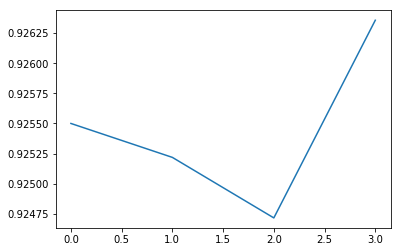

In [11]:
print(f2_history.f2_02_scores)
plt.plot(f2_history.f2_02_scores)
plt.show()

[0.90582309427298102, 0.90319904603392687, 0.90571481853285685, 0.9040055617734486]


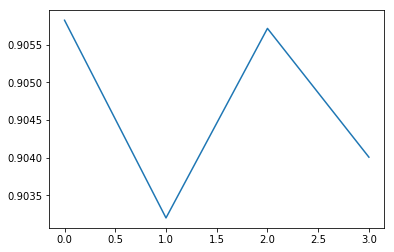

In [12]:
print(f2_history.f2_05_scores)
plt.plot(f2_history.f2_05_scores)
plt.show()

In [15]:
stop

NameError: name 'stop' is not defined

In [12]:
del model
model = load_model(DATA_DIR+'/models/'+model_name+'_'+str(fold_inx)+'.h5', compile=False)

opt=optimizers.Adam(lr=1e-5, decay=0.1e-6); epochs=5;
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fn_loss, f2, 'accuracy'])

In [ ]:
# model.fit_generator(
#     generator=valid_gen.flow(train_array[valid_folds[fold_inx]], Y[valid_folds[fold_inx]], batch_size=batch_size),
#     steps_per_epoch=valid_steps,
#     epochs=epochs)

In [17]:
model.evaluate(train_array[valid_folds[fold_inx]], Y[valid_folds[fold_inx]], batch_size=batch_size)

4049/4049 [==============================] - 28s    


[0.083004178551537924,
 0.10162896704260847,
 0.90810794520755955,
 0.96777706225438309]

In [9]:
# backup
model.evaluate(train_array[valid_folds[fold_inx]], Y[valid_folds[fold_inx]], batch_size=batch_size)

4049/4049 [==============================] - 30s    


[0.082936968979172479,
 0.10173609103868554,
 0.90722207514920261,
 0.96784970512446666]

In [13]:
model.evaluate_generator(
    valid_gen.flow(train_array[valid_folds[fold_inx]], Y[valid_folds[fold_inx]], batch_size=batch_size, shuffle=False),
    steps=valid_steps)

[0.084928487579111228,
 0.10477362035836488,
 0.90433176104534518,
 0.96761726280529425]

In [ ]:
# model.evaluate_generator(
#     all_gen.flow(train_array, Y, batch_size=batch_size, shuffle=False),
#     steps=all_steps)

In [14]:
p_X_no_tta, p_X_tta_list = predictTTA(model, train_array, all_gen, all_steps, batch_size, 3)
p_X_tta = sum(p_X_tta_list)

40479/40479 [==============================] - 292s   
Predicting TTA: 0
1265/1265 [==============================] - 291s   
Predicting TTA: 1
1265/1265 [==============================] - 292s   
Predicting TTA: 2
1265/1265 [==============================] - 292s   


In [33]:
c = 1.0
p_X = (c*p_X_no_tta+p_X_tta)/(c+3.0)

In [34]:
start = time()
thres = find_best_thresholds(Y[valid_folds[fold_inx]], p_X[valid_folds[fold_inx]])
print("F2 Valid Score: {}".format(f2_score(Y[valid_folds[fold_inx]], p_X[valid_folds[fold_inx]], thres)))
print("F2 All Score: {}".format(f2_score(Y, p_X, thres)))

save_array(DATA_DIR+'/models/'+model_name+'_thres_'+str(fold_inx)+'.dat', thres)
print(time() - start)

/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


5: Score 0.9284142154765906 with 0.1205
1: Score 0.928118066471266 with 0.223
3: Score 0.9281417097101912 with 0.223
6: Score 0.9293319718873996 with 0.059500000000000004
2: Score 0.9282179895997462 with 0.232
4: Score 0.928111100038312 with 0.209
0: Score 0.928515327452937 with 0.2775
7: Score 0.9281242190574234 with 0.10300000000000001
8: Score 0.9284581875544817 with 0.2125
10: Score 0.9283823018227934 with 0.2725
9: Score 0.9282558706171348 with 0.162
11: Score 0.9282937379525887 with 0.1825
12: Score 0.9283357745158884 with 0.244
14: Score 0.9283664466191361 with 0.109
13: Score 0.9282059493343886 with 0.2175
15: Score 0.9281095878224549 with 0.156
16: Score 0.928200329514459 with 0.158
F2 Valid Score: 0.932087272429834
F2 All Score: 0.9358597884540638
28.40216827392578


In [35]:
# thres = load_array(DATA_DIR+'/models/'+model_name+'_thres_'+str(fold_inx)+'.dat')
print(f2_score(Y[valid_folds[fold_inx]], p_X[valid_folds[fold_inx]], thres))
print(f2_score(Y, p_X, thres))

0.93208727243
0.935859788454


In [ ]:
# max_f2 = 0.0
# best_c = 0.0
# for c in np.arange(0, 2, 0.2):
#     print(c)
#     p_X = (c*p_X_no_tta+p_X_tta)/(c+3.0)
#     thres = find_best_thresholds(Y[valid_folds[fold_inx]], p_X[valid_folds[fold_inx]])
#     current_f2 = f2_score(Y[valid_folds[fold_inx]], p_X[valid_folds[fold_inx]], thres)
    
#     print("F2 Valid Score: {}".format(current_f2))
#     print("F2 All Score: {}".format(f2_score(Y, p_X, thres)))
    
#     if current_f2>max_f2:
#         max_f2 = current_f2
#         best_c = c

# print(max_f2)
# print(best_c)

In [36]:
del train_array
del p_X
del p_X_no_tta
del p_X_tta
del p_X_tta_list
del model
del thres

start = time()
model = load_model(DATA_DIR+'/models/'+model_name+'_'+str(fold_inx)+'.h5', compile=False)
thres = load_array(DATA_DIR+'/models/'+model_name+'_thres_'+str(fold_inx)+'.dat')

test_array = load_array(DATA_DIR+'/test_images_'+str(image_size)+'.dat')
print(time() - start)

20.005693435668945


In [37]:
p_X_test_no_tta, p_X_test_tta_list = predictTTA(model, test_array, test_gen, test_steps, batch_size, 3)
p_X_test_tta = sum(p_X_test_tta_list)

61191/61191 [==============================] - 437s   
Predicting TTA: 0
1913/1913 [==============================] - 440s   
Predicting TTA: 1
1913/1913 [==============================] - 441s   
Predicting TTA: 2
1913/1913 [==============================] - 441s   


In [57]:
c = 3.0
p_X_test = (c*p_X_test_no_tta+p_X_test_tta)/(c+3.0)
p_X_test = p_X_test_no_tta

In [58]:
start = time()
for inx in np.arange(len(test_df)):
    test_df['tags'][inx] = ' '.join([inv_label_map[i] for i, b in enumerate(p_X_test[inx] >= thres) if b])
print(time() - start)

test_df[:10]

14.894867181777954


,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,agriculture clear cultivation primary
4,test_4,cloudy partly_cloudy primary
5,test_5,clear primary
6,test_6,agriculture clear cultivation habitation partl...
7,test_7,agriculture clear habitation primary road
8,test_8,clear primary
9,test_9,agriculture clear cultivation haze primary


In [59]:
save_array(DATA_DIR+'/results/'+model_name+'_test.dat', p_X_test)
test_df.to_csv(DATA_DIR+'/results/'+model_name+'_submission.csv', index=False)
FileLink('data/results/'+model_name+'_submission.csv')

/src/DL/planet_understanding_the_amazon_from_space/data/results/deep_model_vgg19_submission.csv

In [41]:
print((time() - global_start)/60)

69.27662885983786
